In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import math
from sampling import NestedSampling, Uniform, Callback, Normal, SamplingException

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import KalmanFilter as KF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_continuous_white_noise

import progressbar

from clemb.forward_model import forward_model, fullness, esol
import clemb

## Table of contents
---------------------------
1. [Data preparation](#Data preparation)
2. [Inversion](#Inversion)

## Data preparation

In [2]:
def common_date(date):
    """
    Function used for pandas group-by.
    If there are several measurements in 
    one day, take the mean.
    """
    ndt = pd.Timestamp(year=date.year,
                       month=date.month,
                       day=date.day)
    return ndt

In [3]:
def interpolate_mg(df, dt=1):
    """
    Inter- and extrapolate Mg++ measurements using a
    non-linear Kalman filter.
    """
    
    def f_x(x, dt):
        """
        Forward model exponential decay
        """
        _k = x[1]/1e3
        _dt = dt
        _y = x[0]
        if isinstance(dt, np.ndarray):
            _dt = dt[0]
        # 4th order Runge-Kutta
        k0 = -_k * _y * _dt
        k1 = -_k * (_y + 0.5 * k0) * _dt
        k2 = -_k * (_y + 0.5 * k1) * _dt
        k3 = -_k * (_y + k2) * _dt
        _y_next = _y + 1./6.*(k0 + 2 * k1 + 2 * k2 + k3)
        return np.array([_y_next, x[1]])

    def h_x(x):
        """
        Measurement function
        """
        return [x[0]]
    
    dts = np.r_[0, np.cumsum(np.diff(df.index).astype(int)/(86400*1e9))]
    dts = dts[:, np.newaxis]
    ny = df['obs'].values
    ny = np.where(np.isnan(ny), None, ny)
    
    points = MerweScaledSigmaPoints(n=2, alpha=.01, beta=2., kappa=1.)
    kf = UKF(dim_x=2, dim_z=1, dt=dt, fx=f_x, hx=h_x, points=points)
    kf.x = np.array([ny[0], .6])
    kf.Q = Q_continuous_white_noise(2, dt=dt, spectral_density=1e-5)
    kf.P = np.diag([100.**2, 3.**2])
    kf.R = 50.**2
    npoints = dts.size
    means = np.zeros((npoints-1, 2))
    covariances = np.zeros((npoints-1, 2, 2))
    for i, z_n in enumerate(ny[1:]):
        kf.predict()
        kf.update(z_n)
        means[i,:] = kf.x
        covariances[i, :, :] = kf.P
    Ms, P, K = kf.rts_smoother(means, covariances)
    y_new = np.r_[ny[0], Ms[:,0]]
    y_std = np.r_[50, np.sqrt(P[:, 0, 0])]
    return pd.DataFrame({'obs': y_new,
                         'obs_err': y_std,
                         'orig': df['obs'].values},
                        index=df.index)

In [4]:
def get_mg_data(tstart=None, tend=datetime.datetime.utcnow().strftime("%Y-%m-%d")):
    # Get Mg++ concentration
    url = "https://fits.geonet.org.nz/observation?siteID=RU003&typeID=Mg-w"
    names = ['obs', 'obs_err']
    mg_df = pd.read_csv(url, index_col=0, names=names, skiprows=1,
                        parse_dates=True)
    if tstart is not None:
        tstart = max(mg_df.index.min(), pd.Timestamp(tstart))
    else:
        tstart = mg_df.index.min()
    mg_df = mg_df.loc[(mg_df.index >= tstart) & (mg_df.index <= tend)]

    mg_df = mg_df.groupby(common_date, axis=0).mean()
    new_dates = pd.date_range(start=tstart, end=tend, freq='D')
    mg_df = mg_df.reindex(index=new_dates)
    # Find the first non-NaN entry
    tstart_min = mg_df.loc[~mg_df['obs'].isnull()].index[0]
    # Ensure the time series starts with a non-NaN value
    mg_df = mg_df.loc[mg_df.index >= tstart_min]
    return interpolate_mg(mg_df)

tstart = '2009-09-25'
df1 = get_mg_data(tstart=tstart)
df1.head()


,obs,obs_err,orig
2009-10-31,1164.000000,50.000000,1164.0
2009-11-01,1133.110720,24.715682,NaN
2009-11-02,1132.401109,24.647722,NaN
2009-11-03,1131.702397,24.579955,NaN
2009-11-04,1131.014561,24.512371,NaN


<IPython.core.display.Javascript object>


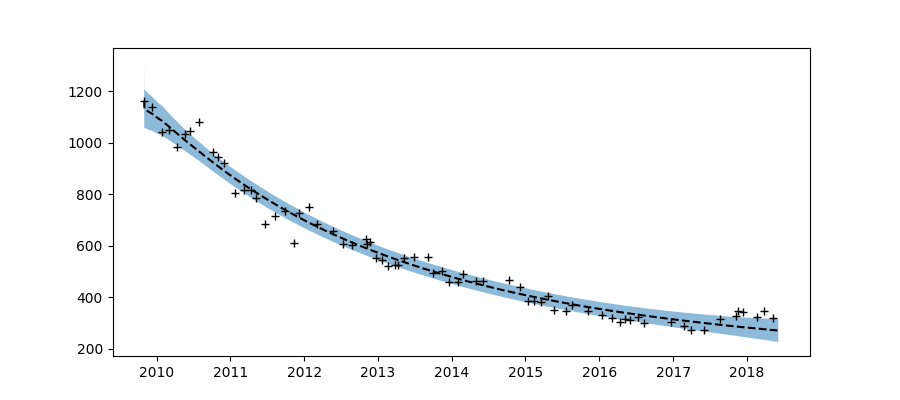

In [5]:
plt.figure(figsize=(9,4))
plt.plot(df1.index, df1['obs'], 'k--')
plt.fill_between(df1.index, df1['obs']-3*df1['obs_err'],
                  df1['obs']+3*df1['obs_err'], alpha=0.5)
plt.plot(df1.index, df1['orig'], 'k+')


In [6]:
def interpolate_T(df, dt=1):
    dts = np.r_[0, np.cumsum(np.diff(df.index).astype(int)/(86400*1e9))]
    dts = dts[:, np.newaxis]
    ny = df['t'].values
    ny = np.where(np.isnan(ny), None, ny)
    
    kf = KF(dim_x=2, dim_z=1)
    kf.F = np.array([[1, 1], [0, 1]])
    kf.H = np.array([[1., 0]])
    if ny[1] is not None:
        dT0 = ny[1] - ny[0]
    else:
        dT0 = 0.
    kf.x = np.array([ny[0], dT0])
    kf.Q = Q_continuous_white_noise(2, dt=dt, spectral_density=3e-2)
    kf.P *= 1e-5**2
    kf.R = .5**2
    means, covariances, _, _ =kf.batch_filter(ny[1:])
    Ms, P, _, _ = kf.rts_smoother(means, covariances)
    y_new = np.r_[ny[0], Ms[:,0]]
    y_std = np.r_[.3, np.sqrt(P[:, 0, 0])]
    return pd.DataFrame({'t': y_new,
                         't_err': y_std,
                         't_orig': df['t'].values},
                         index=df.index)

In [7]:
def get_T(tstart=None, tend=datetime.datetime.utcnow().strftime("%Y-%m-%d")):        
    # Get temperature
    # Temperature has been recorded by 3 different sensors so 3 individual
    # requests have to be made
    url = "https://fits.geonet.org.nz/observation?siteID=RU001&typeID=t&methodID={}"
    names = ['t', 't_err']
    tdf1 = pd.read_csv(url.format('therm'),
                       index_col=0, names=names, skiprows=1,
                       parse_dates=True)
    tdf2 = pd.read_csv(url.format('thermcoup'),
                       index_col=0, names=names, skiprows=1,
                       parse_dates=True)
    tdf3 = pd.read_csv(url.format('logic'),
                       index_col=0, names=names, skiprows=1,
                       parse_dates=True)
    tdf3 = tdf3.combine_first(tdf2)
    t_df = tdf3.combine_first(tdf1)
    if tstart is not None:
        tstart = max(t_df.index.min(), pd.Timestamp(tstart))
    else:
        tstart = t_df.index.min()
    t_df = t_df.loc[(t_df.index >= tstart) & (t_df.index <= tend)]
    t_df = t_df.groupby(common_date, axis=0).mean()
    new_dates = pd.date_range(start=tstart, end=tend, freq='D')
    t_df = t_df.reindex(index=new_dates)
    # Find the first non-NaN entry
    tstart_min = t_df.loc[~t_df['t'].isnull()].index[0]
    # Ensure the time series starts with a non-NaN value
    t_df = t_df.loc[t_df.index >= tstart_min]
    return interpolate_T(t_df)

df2 = get_T(tstart=df1.index[0], tend=df1.index[-1])
#df2 = get_T()
df2.head()

,t,t_err,t_orig
2009-10-31,25.359167,0.300000,25.359167
2009-11-01,25.405773,0.072490,25.431250
2009-11-02,25.402304,0.146968,25.241250
2009-11-03,25.348644,0.193517,25.807917
2009-11-04,25.241486,0.216337,25.323750


<IPython.core.display.Javascript object>


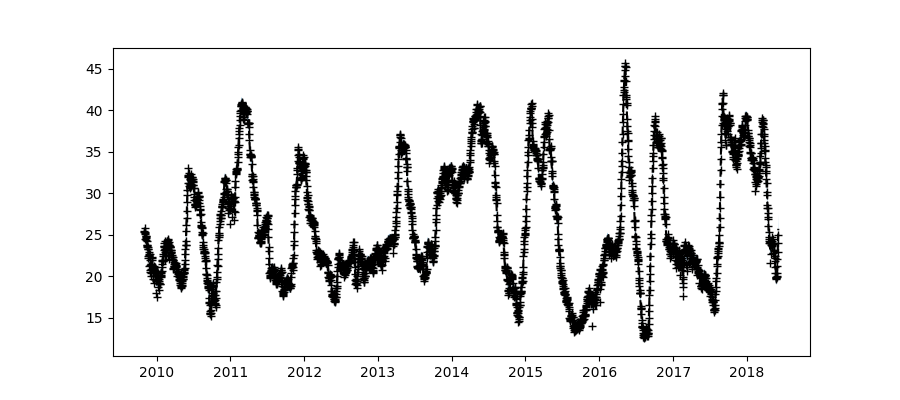

In [8]:
plt.figure(figsize=(9,4))
plt.plot(df2.index, df2['t'], 'k--')
plt.fill_between(df2.index, df2['t']-3*df2['t_err'],
                  df2['t']+3*df2['t_err'], alpha=0.5)
plt.plot(df2.index, df2['t_orig'], 'k+')


In [9]:
def interpolate_ll(df, dt=1):
    dts = np.r_[0, np.cumsum(np.diff(df.index).astype(int)/(86400*1e9))]
    dts = dts[:, np.newaxis]
    ny = df['h'].values
    ny = np.where(np.isnan(ny), None, ny)
    
    kf = KF(dim_x=1, dim_z=1)
    kf.F = np.array([[1.]])
    kf.H = np.array([[1.]])
    if ny[1] is not None:
        dT0 = ny[1] - ny[0]
    else:
        dT0 = 0.
    kf.x = np.array([ny[0]])
    kf.Q = 1e-2**2
    kf.P = 0.03**2
    kf.R = 0.02**2
    means, covariances, _, _ =kf.batch_filter(ny[1:])
    Ms, P, _, _ = kf.rts_smoother(means, covariances)
    y_new = np.r_[ny[0], Ms[:,0]]
    y_std = np.r_[0.03, np.sqrt(P[:, 0, 0])]
    return pd.DataFrame({'h': y_new,
                         'h_err': y_std,
                         'h_orig': df['h'].values},
                         index=df.index)

In [10]:
def get_ll(tstart=None, tend=datetime.datetime.utcnow().strftime("%Y-%m-%d")):
    # Get lake level
    # The lake level data is stored with respect to the overflow level of
    # the lake. Unfortunately, that level has changed over time so to get
    # the absolute lake level altitude, data from different periods have to
    # be corrected differently. Also, lake level data has been measured by
    # different methods requiring several requests.
    url = "https://fits.geonet.org.nz/observation?siteID={}&typeID=z"
    names = ['h', 'h_err']
    ldf = pd.read_csv(url.format('RU001'),
                      index_col=0, names=names, skiprows=1,
                      parse_dates=True)
    ldf1 = pd.read_csv(url.format('RU001A'),
                       index_col=0, names=names, skiprows=1,
                       parse_dates=True)
    ll_df = ldf.combine_first(ldf1)
    ll_df.loc[ll_df.index < '1997-01-01', 'h'] = 2530. + \
        ll_df.loc[ll_df.index < '1997-01-01', 'h']
    ll_df.loc[(ll_df.index > '1997-01-01') & (ll_df.index < '2012-12-31'), 'h'] = 2529.5 + \
              (ll_df.loc[(ll_df.index > '1997-01-01') & (ll_df.index < '2012-12-31'), 'h'] - 1.3)
    ll_df.loc[ll_df.index > '2016-01-01', 'h'] = 2529.35 + (ll_df.loc[ll_df.index > '2016-01-01', 'h'] - 2.0)
    
    if tstart is not None:
        tstart = max(ll_df.index.min(), pd.Timestamp(tstart))
    else:
        tstart = ll_df.index.min()
    ll_df = ll_df.loc[(ll_df.index >= tstart) & (ll_df.index <= tend)]
    ll_df = ll_df.groupby(common_date, axis=0).mean()
    new_dates = pd.date_range(start=tstart, end=tend, freq='D')
    ll_df = ll_df.reindex(index=new_dates)
    # Find the first non-NaN entry
    tstart_min = ll_df.loc[~ll_df['h'].isnull()].index[0]
    # Ensure the time series starts with a non-NaN value
    ll_df = ll_df.loc[ll_df.index >= tstart_min]
    return interpolate_ll(ll_df)

df3 = get_ll(tstart=df1.index[0], tend=df1.index[-1])
df3.head()

,h,h_err,h_orig
2009-10-31,2528.659708,0.030000,2528.659708
2009-11-01,2528.623710,0.011622,2528.646292
2009-11-02,2528.614465,0.010543,2528.625292
2009-11-03,2528.602513,0.010113,2528.614792
2009-11-04,2528.587491,0.009948,2528.594333


<IPython.core.display.Javascript object>


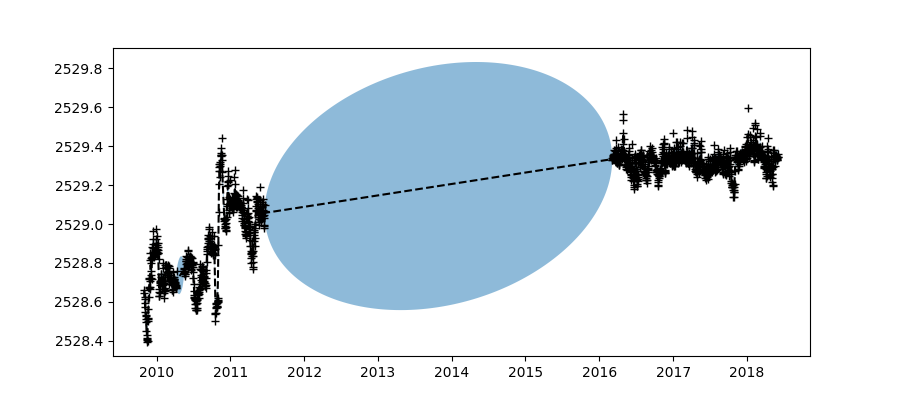

In [11]:
plt.figure(figsize=(9,4))
plt.plot(df3.index, df3['h'], 'k--')
plt.fill_between(df3.index, df3['h']-3*df3['h_err'],
                  df3['h']+3*df3['h_err'], alpha=0.5)
plt.plot(df3.index, df3['h_orig'], 'k+')


In [81]:
def derived_obs(df1, df2, df3, nsamples=100):
    """
    Compute absolute amount of Mg++, volume, lake aread,
    water density and lake mass using Monte Carlo sampling
    """
    rn1 = np.random.randn(df1['obs'].size, nsamples)
    rn1 = rn1*np.tile(df1['obs_err'].values, (nsamples,1)).T + np.tile(df1['obs'].values, (nsamples,1)).T

    rn2 = np.random.randn(df3['h'].size, nsamples)
    rn2 = rn2*np.tile(df3['h_err'].values, (nsamples, 1)).T + np.tile(df3['h'].values, (nsamples,1)).T
    a, vol = fullness(rn2)
    X = rn1*vol
    
    p_mean = 1.003 - 0.00033 * df2['t'].values
    p_std = 0.00033*df2['t_err'].values
    
    rn3 = np.random.randn(p_mean.size, nsamples)
    rn3 = rn3*np.tile(p_std, (nsamples, 1)).T + np.tile(p_mean, (nsamples,1)).T
    M = rn3*vol
    return (X.mean(axis=1), X.std(axis=1), vol.mean(axis=1), vol.std(axis=1),
            p_mean, p_std, M.mean(axis=1), M.std(axis=1),
            a.mean(axis=1), a.std(axis=1))
X, X_err, v, v_err, p, p_err, M, M_err, a, a_err = derived_obs(df1, df2, df3, nsamples=20000)

In [82]:
df = pd.DataFrame({'T': df2['t'],
                   'T_err': df2['t_err'],
                   'z': df3['h'],
                   'z_err': df3['h_err'],
                   'Mg': df1['obs'],
                   'Mg_err': df1['obs_err'],
                   'X': X,
                   'X_err': X_err,
                   'v': v,
                   'v_err': v_err,
                   'a': a,
                   'a_err': a_err,
                   'p': p,
                   'p_err': p_err,
                   'M': M,
                   'M_err': M_err})
df

,M,M_err,Mg,Mg_err,T,T_err,X,X_err,a,a_err,p,p_err,v,v_err,z,z_err
2009-10-31,8692.790248,5.810141,1164.000000,50.000000,25.359167,0.300000,1.017334e+07,438770.879150,194161.974652,89.172581,0.994631,0.000099,8739.709606,5.775011,2528.659708,0.030000
2009-11-01,8685.713749,2.222581,1133.110720,24.715682,25.405773,0.072490,9.896329e+06,215054.162315,194054.191742,34.378516,0.994616,0.000024,8732.729650,2.225961,2528.623710,0.011622
2009-11-02,8683.979695,2.053791,1132.401109,24.647722,25.402304,0.146968,9.885461e+06,214718.115385,194027.088172,31.243860,0.994617,0.000048,8730.974764,2.022890,2528.614465,0.010543
2009-11-03,8681.807813,1.996961,1131.702397,24.579955,25.348644,0.193517,9.877888e+06,213790.729503,193991.044068,29.860103,0.994635,0.000064,8728.641157,1.933163,2528.602513,0.010113
2009-11-04,8679.252416,2.009841,1131.014561,24.512371,25.241486,0.216337,9.868111e+06,213198.376015,193946.460700,29.570265,0.994670,0.000071,8725.754924,1.914232,2528.587491,0.009948
2009-11-05,8676.444432,2.006611,1130.337582,24.444964,25.112689,0.225069,9.858347e+06,213734.376194,193897.071454,29.512805,0.994713,0.000074,8722.557862,1.910331,2528.570759,0.009886
2009-11-06,8673.418536,1.999192,1129.671440,24.377724,24.998067,0.227468,9.851289e+06,213639.086171,193845.143997,29.318763,0.994751,0.000075,8719.196828,1.897577,2528.553435,0.009863
2009-11-07,8670.639173,2.006134,1129.016113,24.310642,24.890887,0.227835,9.841813e+06,209626.593267,193797.183040,29.479287,0.994786,0.000075,8716.092832,1.907787,2528.537251,0.009855
2009-11-08,8668.026944,1.996553,1128.371582,24.243711,24.784713,0.227848,9.830746e+06,209735.522324,193751.721981,29.298313,0.994821,0.000075,8713.150893,1.895909,2528.522004,0.009851
2009-11-09,8665.068539,2.000460,1127.737828,24.176920,24.672302,0.227894,9.822260e+06,210772.110758,193700.850856,29.412794,0.994858,0.000075,8709.859161,1.903128,2528.504769,0.009850


In [83]:
df.to_hdf('measurements.h5','table')

## Inversion

In [2]:
df = pd.read_hdf('measurements.h5', 'table')

In [3]:
class PyCallback(Callback):
    """
    Callback function to compute the log-likelihood for nested sampling.
    """
    
    def __init__(self):
        Callback.__init__(self)
        
    def set_data(self, y0, y1, cov, vol, a, solar, dt, ws):
        self.y0 = y0
        self.y1 = y1
        self.ws = ws
        self.vol = vol
        self.a = a
        self.solar = solar
        self.dt = dt
        self.cov = cov
        # the precision matrix is the inverse of the 
        # covariance matrix
        self.prec = np.linalg.inv(cov)
        self.factor = -np.log(np.power(2.*np.pi, self.cov.shape[0]) + np.sqrt(np.linalg.det(self.cov)))
        self.y_new = None

    def run(self, vals):
        try:
            Q_in = vals[0]*0.0864
            M_melt = vals[1]
            Mout = vals[2]*86400.*1.e-6 # convert l/s into 1e3 m^3/day
            H = 6.

            y_new, steam, mevap = forward_model(self.y0, dt, self.a, self.vol, Q_in, 
                                     M_melt, Mout, self.solar, H, self.ws)
            self.y_new = y_new
            lh = self.factor - 0.5*np.dot(y_new-self.y1,np.dot(self.prec,y_new-self.y1))
        except:
            raise SamplingException("Oh no!")
        return lh



In [31]:
startdate = '2018-02-01'

ndf = df.loc[df.index >= startdate]
datetime = ndf.index

nsteps = ndf.shape[0] - 1
dt = 1.

nsamples = 4000
nresample = 100
nparams = 3

qin = Uniform('qin', 0, 800)
m_in = Uniform('m_in', 0, 20)
#h = Normal('h', 6., .5)
m_out = Uniform('m_out', 30, 80)
ws = 4.5

# return values
qin_samples = np.zeros((nsteps, nresample))
m_in_samples = np.zeros((nsteps, nresample))
m_out_samples = np.zeros((nsteps, nresample))
h_samples = np.zeros((nsteps, nresample))
lh = np.zeros((nsteps, nresample))
exp = np.zeros((nsteps, nparams))
var = np.zeros((nsteps, nparams))
model_data = np.zeros((nsteps, nresample, 3))
steam = np.zeros((nsteps, nresample))
mevap = np.zeros((nsteps, nresample))

ns = NestedSampling()
pycb = PyCallback()
pycb.__disown__()
ns.setCallback(pycb)

with progressbar.ProgressBar(max_value=nsteps-1) as bar:
    for i in range(nsteps):
        a = ndf['a'][i]
        vol = ndf['v'][i]
        solar = esol(i*dt, a, datetime)
        # Take samples from the input
        T = ndf['T'][i]
        T_sigma = ndf['T_err'][i+1]
        M = ndf['M'][i]
        M_sigma = ndf['M_err'][i+1]
        X = ndf['X'][i]
        X_sigma = ndf['X_err'][i+1]
        cov = np.array([[T_sigma, 0., 0.],[0., M_sigma, 0.], [0., 0., X_sigma]])
        T_next = ndf['T'][i+1]
        M_next = ndf['M'][i+1]
        X_next = ndf['X'][i+1]

        y = np.array([T, M, X])
        y_next = np.array([T_next, M_next, X_next])
        pycb.set_data(y, y_next, cov, vol, a, solar, dt, ws)
        rs = ns.explore(vars=[qin, m_in, m_out], initial_samples=100,
                        maximum_steps=nsamples)
        smp = rs.resample_posterior(nresample)
        exp[i,:] = rs.getexpt()
        var[i,:] = rs.getvar()
        for j,_s in enumerate(smp):
            Q_in = _s._vars[0].get_value()
            M_in = _s._vars[1].get_value()
            M_out = _s._vars[2].get_value()
            #H = _s._vars[3].get_value()
            y_mod, st, me = forward_model(y, dt, a, vol, Q_in*0.0864, 
                                          M_in, M_out, solar, 6., ws)
            steam[i, j] = st
            mevap[i, j] = me
            model_data[i, j, :] = y_mod
            qin_samples[i, j] = Q_in
            m_in_samples[i, j] = M_in
            m_out_samples[i, j] = M_out
            #h_samples[i, j] = H
            lh[i, j] = np.exp(_s._logL)
        del smp
        bar.update(i)


100% (124 of 124) |######################| Elapsed Time: 0:05:06 Time:  0:05:06


In [32]:
if False:
    c = clemb.Clemb(clemb.LakeDataFITS(), clemb.WindDataCSV(), start=startdate, end=ndf.index[-1])
    rp = c.run([0,1])
    rp.to_hdf('clemb_output.h5','table')
else:
    rp = pd.read_hdf('clemb_output.h5', 'table')
pwr = rp.loc[0,'pwr']
melt = rp.loc[0,'fmelt']
orig_mevap = rp.loc[0, 'evfl']
orig_steam = rp.loc[0, 'steam']

<IPython.core.display.Javascript object>


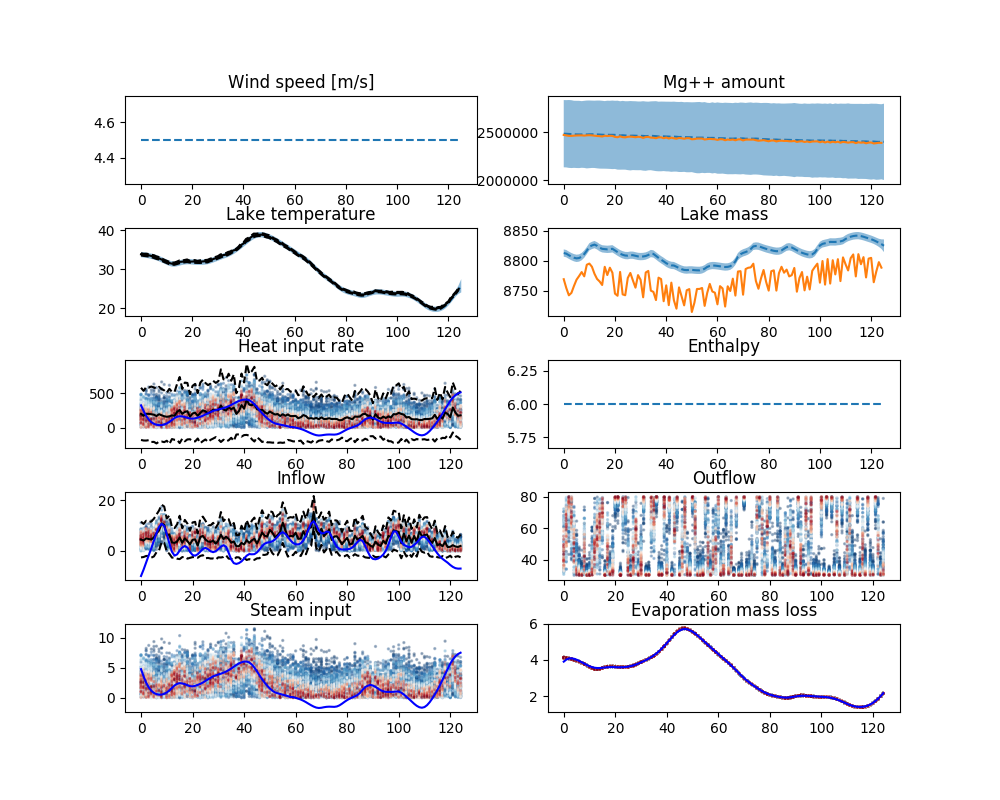

Text(0.5,1,'Evaporation mass loss')

In [33]:
mpl.rcParams['figure.subplot.hspace'] = 0.5
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 8))

axs[0,0].plot(np.arange(nsteps+1), np.ones(ndf.index.size)*4.5, ls='--')
axs[0,0].set_title('Wind speed [m/s]')

axs[0,1].plot(np.arange(nsteps+1), ndf['X'], ls='--')

axs[0,1].fill_between(np.arange(nsteps+1), ndf['X']-3*ndf['X_err'],
                      ndf['X']+3*ndf['X_err'], alpha=0.5)
axs[0,1].plot(np.arange(nsteps), model_data[:,:,2].mean(axis=1))
axs[0,1].set_title('Mg++ amount')

axs[1,0].plot(np.arange(nsteps+1), ndf['T'], ls='--')
axs[1,0].fill_between(np.arange(nsteps+1), ndf['T']-3*ndf['T_err'],
                      ndf['T']+3*ndf['T_err'], alpha=0.5)
#for k in range(nsteps):
#    axs[1,0].scatter(np.ones(nresample)*k, model_data[k,:,0], s=2, c=lh[k],
#                     cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
axs[1,0].plot(np.arange(nsteps), model_data[:,:,0].mean(axis=1), 'k-')
axs[1,0].plot(np.arange(nsteps),
              model_data[:,:,0].mean(axis=1)+model_data[:,:,0].std(axis=1),
             'k--')
axs[1,0].plot(np.arange(nsteps),
              model_data[:,:,0].mean(axis=1)-model_data[:,:,0].std(axis=1),
              'k--')
axs[1,0].set_title('Lake temperature')

axs[1,1].plot(np.arange(nsteps+1), ndf['M'], ls='--')
axs[1,1].fill_between(np.arange(nsteps+1), ndf['M']-3*ndf['M_err'],
                      ndf['M']+3*ndf['M_err'], alpha=0.5)
axs[1,1].plot(np.arange(nsteps), model_data[:,:,1].mean(axis=1))
axs[1,1].set_title('Lake mass')

for k in range(nsteps):
    axs[2,0].scatter(np.ones(nresample)*k, qin_samples[k], s=2, c=lh[k],
                     cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
axs[2,0].plot(np.arange(nsteps), exp[:,0], 'k')
axs[2,0].plot(np.arange(nsteps), exp[:,0] - 3*np.sqrt(var[:,0]), 'k--')
axs[2,0].plot(np.arange(nsteps), exp[:,0] + 3*np.sqrt(var[:,0]), 'k--')
axs[2,0].plot(np.arange(nsteps), pwr.values, 'b-')
axs[2,0].set_title('Heat input rate')

if False:
    for k in range(nsteps):
        axs[2,1].scatter(np.ones(nresample)*k, h_samples[k], s=2, c=lh[k],
                    cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
    axs[2,1].plot(np.arange(nsteps), exp[:,3], 'k')
    axs[2,1].plot(np.arange(nsteps), exp[:,3] - 3*np.sqrt(var[:,3]), 'k--')
    axs[2,1].plot(np.arange(nsteps), exp[:,3] + 3*np.sqrt(var[:,3]), 'k--')
axs[2,1].plot(np.arange(nsteps+1), np.ones(ndf.index.size)*6.0, ls='--')
axs[2,1].set_title('Enthalpy')

for k in range(nsteps):
    axs[3,0].scatter(np.ones(nresample)*k, m_in_samples[k], s=2, c=lh[k],
                cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
axs[3,0].plot(np.arange(nsteps), exp[:,1], 'k')
axs[3,0].plot(np.arange(nsteps), exp[:,1] - 3*np.sqrt(var[:,1]), 'k--')
axs[3,0].plot(np.arange(nsteps), exp[:,1] + 3*np.sqrt(var[:,1]), 'k--')
axs[3,0].plot(np.arange(nsteps), melt.values, 'b-')
axs[3,0].set_title('Inflow')

for k in range(nsteps):
    axs[3,1].scatter(np.ones(nresample)*k, m_out_samples[k], s=2, c=lh[k],
                cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
#axs[3,1].plot(np.arange(nsteps), exp[:,3], 'k')
#axs[3,1].plot(np.arange(nsteps), exp[:,3] - 3*np.sqrt(var[:,3]), 'k--')
#axs[3,1].plot(np.arange(nsteps), exp[:,3] + 3*np.sqrt(var[:,3]), 'k--')
axs[3,1].set_title('Outflow')

for k in range(nsteps):
    axs[4,0].scatter(np.ones(nresample)*k, steam[k], s=2, c=lh[k],
                     cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
axs[4,0].plot(np.arange(nsteps), orig_steam.values, 'b-')
axs[4,0].set_title('Steam input')
    
for k in range(nsteps):
    axs[4,1].scatter(np.ones(nresample)*k, mevap[k], s=2, c=lh[k],
                     cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
axs[4,1].plot(np.arange(nsteps), orig_mevap.values, 'b-')
axs[4,1].set_title('Evaporation mass loss')



In [5]:
np.argmin(t)

Timestamp('2017-07-24 00:00:00')

In [6]:
startdate = '2017-06-01'
pwr = df.loc[0,'pwr']*0.0864
pwr = pwr.loc[pwr.index > startdate]
datetime = pwr.index

ll = df.loc[0,'llvl']
ll = ll.loc[ll.index > startdate]

t = df.loc[0,'t']
t = t.loc[t.index > startdate]

i = 80
T0, T1 = t[i:i+2]
l0, l1 = ll[i:i+2]
dt = 1.
time = i*dt
hmin = 0.
hmax = 800.
q_test = Uniform('q_test', hmin, hmax)
m_test = Uniform('m', 0, 20)
h_test = Uniform('h', 0., 100.)
nst = NestedSampling()
pycb = PyCallback()
pycb.__disown__()
nst.setCallback(pycb)

print(T0, T1, pwr[i]/0.0864)

28.4704421479 29.7324703949 664.20306643


In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))


In [8]:
a0, vol0 = fullness(l0)
solar = esol(time, a0, datetime)

T_sigma = 0.3
M_sigma = 1.
cov = np.array([[T_sigma, 0., 0.],[0., M_sigma, 0.], [0., 0., 1.]])

p0 = 1.003 - 0.00033 * T0
M0 = vol0*p0

_,vol1 = fullness(l1)
p1 = 1.003 - 0.00033 * T1
M1 = vol1*p1

nsamples = 10000
y0 = np.array([T0, M0, 0])
y1 = np.array([T1, M1, 0.])
pycb.set_data(y0, y1, cov, vol0, a0, solar, dt, 4.5)
rs = nst.explore(vars=[q_test, m_test, h_test], initial_samples=100,
                maximum_steps=nsamples)


In [9]:
nresample = 1000
smp = rs.resample_posterior(nresample)
print(rs.getexpt())
print([math.sqrt(_v) for _v in rs.getvar()])
qin_samples = []
m_samples = []
h_samples = []
weights = []
logZ = rs.getZ()
for j,_s in enumerate(smp):
    weights.append(math.exp(_s._logWt - logZ[0]))
    qin_samples.append(_s._vars[0].get_value())
    m_samples.append(_s._vars[1].get_value())
    h_samples.append(_s._vars[2].get_value())
print(weighted_avg_and_std(qin_samples, weights))
print(weighted_avg_and_std(m_samples, weights))
print(weighted_avg_and_std(h_samples, weights))

(554.8008103035454, 15.904872465870612, 47.083139843338344)
[172.8713847135873, 3.53987653572579, 31.062481483772384]
(548.16631276471583, 172.17609912320034)
(16.0579754471431, 3.3827126845044773)
(47.495053436850597, 30.686632812083076)


<IPython.core.display.Javascript object>


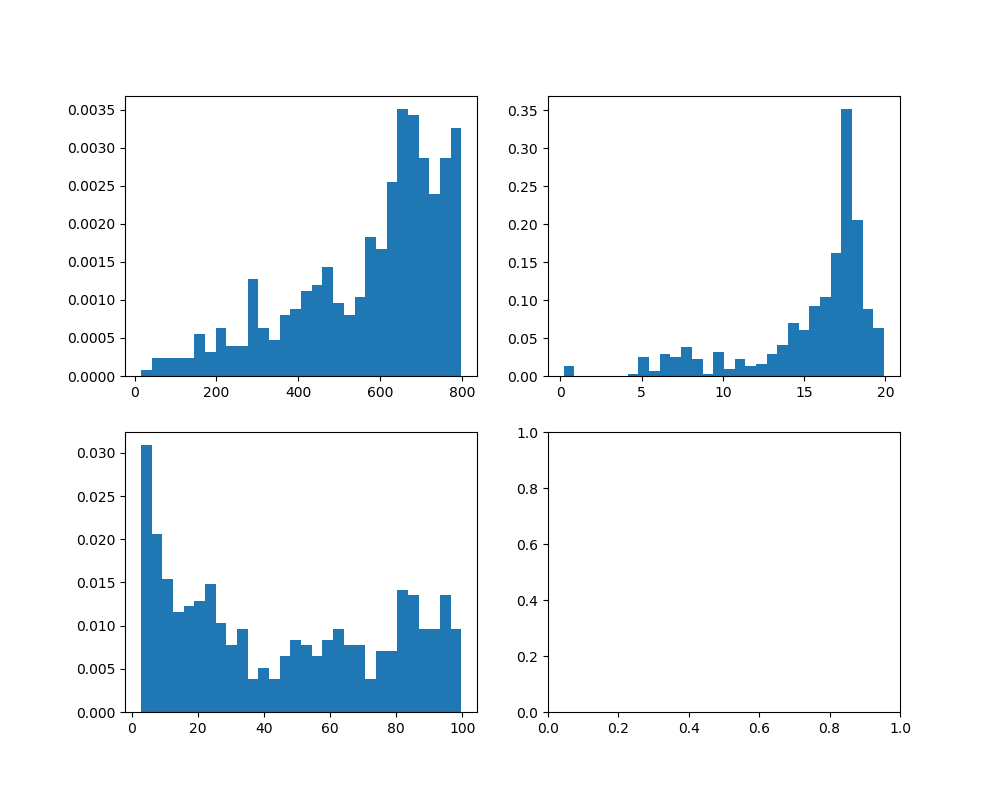

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
_ = axs[0,0].hist(qin_samples, bins=30, density=True)
_ = axs[0,1].hist(m_samples, bins=30, density=True)
_ = axs[1,0].hist(h_samples, bins=30, density=True)

In [77]:
y_new, steam, mevap = forward_model(y0, dt, a0, vol0, qin_samples[-2]*0.0864, 
                                    m_samples[-2], 20., solar, h_samples[-2], 4.5)
print(y_new)
print(y1)

[   29.73246889  8809.65471654     0.        ]
[   29.73247039  8809.65474601     0.        ]


In [12]:
# The following doesn't work because pymc3 can't handle a
# blackbox function call; to make it work it has to be
# implemented as a theano Ops; see also:
# https://github.com/pymc-devs/pymc3/issues/1925
import pymc3 as pm

In [24]:
pycb.set_data(y0, y1, cov, vol0, a0, solar, dt, 4.5)
rs = nst.explore(vars=[q_test, m_test, h_test], initial_samples=100,
                maximum_steps=nsamples)
Mout = 0.
model = pm.Model()
with model:
    q = pm.Uniform('q', hmin, hmax)
    m = pm.Uniform('m', 0, 20)
    h = pm.Uniform('h', 0., 100.)
    y_new, steam, mevap = forward_model(y0, dt, a0, vol0, q*0.0864, 
                                        m, Mout, solar, h, 4.5)
    d_obs = pm.MvNormal('d_obs', mu=y_new, cov=cov, observed=y1)
    trace = pm.sample(chains=1)

AsTensorError: ('Cannot convert [Elemwise{add,no_inplace}.0 Elemwise{add,no_inplace}.0 0.0] to TensorType', <class 'numpy.ndarray'>)

In [25]:
y_new

array([Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, 0.0], dtype=object)

AttributeError: type object 'object' has no attribute '__getattr__'

In [123]:
[math.sqrt(_v) for _v in rs.getvar()]

[167.40218398382217, 3.5465022618852187, 29.363578110993284]

In [167]:
s = pd.HDFStore('clemb_output.h5')
df = s['df']
s.close()

In [126]:
# resample posterior
import math

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

z = rs.getZ()
n = 200.
start = np.random.uniform()
samples = []
new_samples = []
old = 0
max_wk = -1e30
for _i, _s in enumerate(smp):
    wk = np.exp(_s._logWt - z[0])
    max_wk = max(max_wk, wk)
    start += n*wk
    if int(start) > old:
        old = int(start)
        new_samples.append(_s)
    samples.append(start)
print(1./max_wk)
    
new_qin = []
new_m = []
new_h = []
weights = []
for _ns in new_samples:
    weights.append(_ns._logWt - z[0])
    new_qin.append(_ns._vars[0].get_value())
    new_m.append(_ns._vars[1].get_value())
    new_h.append(_ns._vars[2].get_value())
print(weighted_avg_and_std(new_qin, weights))
print(weighted_avg_and_std(new_m, weights))
print(weighted_avg_and_std(new_h, weights))

if False:
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
    _ = axs[0,0].hist(new_qin, normed=True)
    _ = axs[0,1].hist(qin_samples, normed=True)
    _ = axs[1,0].hist(new_m, normed=True)
    _ = axs[1,1].hist(m_samples, normed=True)
    _ = axs[2,0].hist(new_h, normed=True)
    _ = axs[2,1].hist(h_samples, normed=True)

261.585072
(568.65540627527002, 166.86788332030366)
(16.335226733645055, 3.464896381637717)
(49.172959388104758, 28.902576775267818)


In [119]:
np.average?

In [5]:
pycb_test = PyCallback()
y0 = np.array([34.61059558, 8811.53042958, 0.])
y1 = np.array([34.37351908,  8811.63548122, 0.])
vol = 8886.3669380187985
a = 196421.56597900391
solar = 4.4194852345275883
t_sigma = 0.3
M_sigma = 5.
cov = np.array([[t_sigma, 0., 0.],[0., M_sigma, 0.], [0., 0., 1.]])
pycb_test.set_data(y0, y1, cov, vol, a, solar, 1.0, 4.5)
pycb_test.run((600,5,6.))

NameError: name 'dt' is not defined


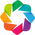

In [48]:
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

In [73]:
data = np.zeros(((nsteps+1)*nsamples,2))
data[:,0] = np.tile(np.arange(nsteps+1), (nsamples,1)).T.ravel()
data[:,1] = qin_samples.ravel()
data

array([[   0.        ,  789.8839507 ],
       [   0.        ,  520.63239854],
       [   0.        ,  635.06452974],
       ..., 
       [ 234.        ,    0.        ],
       [ 234.        ,    0.        ],
       [ 234.        ,    0.        ]])

In [78]:
datashade(hv.Points(data), agg='count')

/usr/local/anaconda3/envs/da/lib/python3.6/site-packages/holoviews/operation/datashader.py:358: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.
  if 'x_axis' in agg and 'y_axis' in agg:


:DynamicMap   []

In [41]:
qin_samples.ravel()[300+10]

381.99601985351018

In [34]:
np.tile(np.arange(5),(2,1)).T.ravel()

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

In [36]:
np.ravel?

### using scipy.ode package

In [ ]:
from scipy.integrate import solve_ivp
def fun(time, state):
    cw = 0.0042
    ws = 4.5
    density = 1.003 - 0.00033 * state[3]
    a, vol = fullness(state[2])
    enth = 6.
    mass = vol*density
    qe, me = es(state[3], ws, a)
    factor = state[3]*cw/(enth - state[3]*cw)
    mi = state[0]/(enth - cw*state[3]) + state[1]*factor
    ms = state[1]
    mout = state[1] - me
    mout=0.
    g0 = fun.dmi(round(time, 4))
    g1 = fun.dms(round(time, 4))
    g2 = fun.dll(round(time,4))
    g3 = 1./(cw*mass)*(-qe + esol(time, a, fun.datetime)  + state[0]*0.0864 -cw*state[3]*mout -cw*state[1]*state[3])
    return np.array([g0, g1, g2, g3])

startdate = '2017-07-15'
pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > startdate]
datetime = pwr.index
pwr_grad = np.gradient(pwr)
time_orig = np.arange(pwr.index.size)
f_mi = interp1d(time_orig, pwr_grad)

melt = df.loc[0,'fmelt']
melt = melt.loc[melt.index > startdate]
melt_grad = np.gradient(melt)
f_ms = interp1d(time_orig, melt_grad)

ll = df.loc[0,'llvl']
ll = ll.loc[ll.index > startdate]
ll_grad = np.gradient(ll)
f_ll = interp1d(time_orig, ll_grad)

t = df.loc[0,'t']
t = t.loc[t.index > startdate]

ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time = np.linspace(0,ndays,nsteps+1)

Mi0 = pwr.values[0]
Ms0 = melt.values[0]
Ll0 = ll.values[0]
T0 = t.values[0]
y0 = [Mi0, Ms0, Ll0, T0]

fun.datetime = datetime
fun.dmi = f_mi
fun.dms = f_ms
fun.dll = f_ll
sol = solve_ivp(fun, [time[0], time[-1]], y0, t_eval=time)
plt.figure()
plt.plot(time_orig, error(sol.y[3,:], t.values[:], sol.t, time_orig))

### Unscented Kalman Filter

In [ ]:
def dT_ca(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = state[3]
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    g3 = 0.
    return np.array([g0, g1, g2, g3])

def dT_cv(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    #g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864 -cw*state[2]*mout)
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1, g2])

def fx_ca(x, dt):
    x_new = rk4(x, time, dt, dT_ca, datetime=fx_ca.datetime)
    x_new[0] += 0.5*dt*dt*x[3]
    return x_new

def fx_cv(x, dt):
    x_new = rk4(x, time, dt, dT_cv, datetime=fx_cv.datetime)
    return x_new

def hx(x):
    return x[2]

In [ ]:
def df_resample(df):
    """
    Resample dataframe to daily sample rate.
    """
    # First upsample to 15 min intervals combined with a linear interpolation
    ndates = pd.date_range(start=df.index.date[0], end=df.index.date[-1],freq='15T')
    ndf = df.reindex(ndates,method='nearest',tolerance=np.timedelta64(15,'m')).interpolate()
    # Then downsample to 1 day intervals assigning the new values to mid day
    ndf = ndf.resample('1D',label='left').mean()
    return ndf

In [ ]:
base_url = "https://fits.geonet.org.nz/observation"
url = "{}?siteID=RU001&networkID=VO&typeID=t&methodID={}"
names = ['t', 't_err']
tdf1 = pd.read_csv(url.format(base_url, 'therm'),index_col=0, names=names, skiprows=1,
                   parse_dates=True)
tdf2 = pd.read_csv(url.format(base_url, 'thermcoup'),index_col=0, names=names, skiprows=1,
                              parse_dates=True)
tdf3 = pd.read_csv(url.format(base_url, 'logic'),index_col=0, names=names, skiprows=1,
                              parse_dates=True)
tdf3 = tdf3.combine_first(tdf2)
tdf3 = tdf3.combine_first(tdf1)
tdf = df_resample(tdf3)
t = tdf.loc[(tdf.index > '2017-01-15')&(tdf.index < '2017-10-13')]
t = t['t']

In [ ]:
from __future__ import (absolute_import, division)
from filterpy.common import dot3
import numpy as np
from numpy import dot, zeros


class IMMEstimator(object):
    """ Implements an Interacting Multiple-Model (IMM) estimator.
    References
    ----------
    Bar-Shalom, Y., Li, X-R., and Kirubarajan, T. "Estimation with
    Application to Tracking and Navigation". Wiley-Interscience, 2001.
    Crassidis, J and Junkins, J. "Optimal Estimation of
    Dynamic Systems". CRC Press, second edition. 2012.
    Labbe, R. "Kalman and Bayesian Filters in Python".
    https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
    """

    def __init__(self, filters, mu, M):
        """"
        Parameters
        ----------
        filters : (N,) array_like of KalmanFilter objects
            List of N filters. filters[i] is the ith Kalman filter in the
            IMM estimator.
        mu : (N,) ndarray of float
            mode probability: mu[i] is the probability that
            filter i is the correct one.
        M : (N,N) ndarray of float
            Markov chain transition matrix. M[i,j] is the probability of
            switching from filter j to filter i.
        """

        assert len(filters) > 1

        self.filters = filters
        self.mu = mu
        self.M = M

        # compute # random variables in the state
        x_shape = (3,)
        n_states = 3
        self.x = np.zeros(x_shape)
        self.P = np.zeros((n_states, n_states))

        self.N = len(filters) # number of filters


    def update(self, z, u=None):
        """
        Add a new measurement (z) to the Kalman filter. If z is None, nothing
        is changed.
        Parameters
        ----------
        z : np.array
            measurement for this update.
        u : np.array, optional
            u[i] contains the control input for the ith filter
        """

        # run update on each filter, and save the likelihood in L
        L = zeros(len(self.filters))
        for i, f in enumerate(self.filters):
            f.predict()
            f.update(z)
            L[i] = f.likelihood

        # initial condition IMM state, covariance
        xs, Ps = [], []
        # each element j = sum M_ij * mu_i
        
        # cbar is the total probability, after interaction, 
        # that the target is in state j. We use it as the
        # normalization constant.
        self.cbar = dot(self.mu, self.M) 

        # compute mixing probabilities
        omega = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                omega[i, j] = (self.M[i, j] * self.mu[i]) / self.cbar[j]

        # compute mixed initial conditions
        for i, (f, w) in enumerate(zip(self.filters, omega.T)):
            x = np.zeros(3)
            for kf, wj in zip(self.filters, w):
                x += kf.x[0:3] * wj
            xs.append(x)
            

            P = np.zeros((3,3))
            for kf, wj in zip(self.filters, w):
                y = kf.x[0:3] - x
                P += wj * (np.outer(y, y) + kf.P[0:3,0:3])
            Ps.append(P)
            

        # perform predict step using the mixed initial conditions
        for i, f in enumerate(self.filters):
            # propagate using the mixed state estimate and covariance
            f.x[0:3] = xs[i]
            f.P[0:3,0:3] = Ps[i]
            f.predict()

        # compute mixed IMM state and covariance
        self.x.fill(0.)
        self.P.fill(0.)

        for f, w in zip(self.filters, self.mu):
            self.x += f.x[0:3] * w

        for f, w in zip(self.filters, self.mu):
            y = f.x[0:3] - self.x
            self.P += w * (np.outer(y, y) + f.P[0:3,0:3])

        # update mode probabilities from total probability * likelihood
        self.mu =  self.cbar * L
        self.mu /= sum(self.mu) # normalize

In [ ]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
import copy

pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > '2017-07-15']
datetime = pwr.index
pwr_grad = np.gradient(pwr)
time_orig = np.arange(pwr.index.size)

#t = df.loc[0,'t']
t = t.loc[t.index > '2017-07-15']
datetime = t.index
tt = np.arange(t.index.size)



ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time_new = np.linspace(0,ndays,nsteps)
To = t.values[0]
Qio = 0
dQio = 0
aQio = 0.

fx_ca.datetime = datetime
points = MerweScaledSigmaPoints(n=4, alpha=.5, beta=2., kappa=-1.)
kf_ca = UKF(4, 1, dt, fx=fx_ca, hx=hx, points=points)
kf_ca.P = np.eye(4)*10
kf_ca.x = np.array([Qio, dQio, To, aQio])
kf_ca.R = np.array([.0001])
a = Q_discrete_white_noise(3, dt=dt, var=100.)
b = np.insert(a, 2, 0., axis=1)
kf_ca.Q = np.insert(b, 2, [0., 0., 0.01, 0.], axis=0)
kf_ca.Q = np.array([[3, 0.1, 0., 0.1], [0.1, 3, 0, 0.1], [0., 0., 0.01, 0.], [0.1, 0.1, 0., 100]])

fx_cv.datetime = datetime
points = MerweScaledSigmaPoints(n=3, alpha=.5, beta=2., kappa=0.)
kf_cv = UKF(3, 1, dt, fx=fx_cv, hx=hx, points=points)
kf_cv.P = np.eye(3)*100
kf_cv.x = np.array([Qio, dQio, To])
kf_cv.R = np.array([1.])
kf_cv.Q = np.eye(3)
kf_cv.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=1.)
kf_cv.Q[2,2] = 0.01

kf_ca1 = copy.deepcopy(kf_ca)
kf_ca1.Q = np.eye(4)
kf_ca1.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf_ca1.Q[2,2] = 0.01
kf_ca1.Q[3,3] = 0.
kf_ca1.x = np.array([Qio, dQio, To, aQio])

kf_cv1 = copy.deepcopy(kf_cv)
kf_cv1.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=100.)

res_mean = []
res_cov = []

filters = [kf_cv1, kf_cv]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])
mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

for i in range(nsteps):
    time = i*dt
    #kf_ca.predict()
    bank.update(t.values[i])
    res_mean.append(bank.x.copy())
    res_cov.append(bank.P.copy())
res_mean = np.array(res_mean)
res_cov = np.array(res_cov)
#(x, P, K) = kf.rts_smoother(res_mean, res_cov)
#res_mean = x
#res_cov = P

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(time_new,res_mean[:,0])
miny = res_mean[:,0] - 3*np.sqrt(res_cov[:,0,0])
maxy = res_mean[:,0] + 3*np.sqrt(res_cov[:,0,0])
plt.fill_between(time_new,miny,maxy,color='b',alpha=0.2)
plt.plot(time_orig, pwr.values)

plt.subplot(1,3,2)
plt.plot(time_new,res_mean[:,2])
miny = res_mean[:,2] - res_cov[:,2,2]
maxy = res_mean[:,2] + res_cov[:,2,2]
plt.fill_between(time_new,miny,maxy,color='b',alpha=0.2)
plt.plot(tt, t.values)
plt.subplot(1,3,3)
plt.plot(time_new,res_mean[:,1])
plt.plot(time_orig, pwr_grad)

### Particle Filter

In [ ]:
from scipy.stats import gamma, norm
x = np.linspace(0,800,1000)
rv = gamma(1.8,0,180)
plt.plot(x, rv.pdf(x))
plt.hist(pwr, normed=True)

In [ ]:
x = np.linspace(-100.,100.,5000)
plt.plot(x, norm(0, 40).pdf(x))
plt.hist(np.gradient(pwr), normed=True)

In [ ]:
np.random.random()*0.01

In [ ]:
def create_initial_particles(N):
    T0 = np.ones(N)*t.values[0]
    Enth0 = np.ones(N)*70.
    Ms0 = np.ones(N)*1.
    particles = np.zeros((N,5))
    particles[:,0] = gamma(1., 0, 80).rvs(size=N)
    particles[:,1] = norm(0, 40).rvs(size=N)
    particles[:,2] = T0
    particles[:,3] = Enth0
    particles[:,4] = Ms0
    return particles

In [ ]:
def deriv(state, time):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(state[3] - cw*state[2])
    ms = state[4]
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    g2 = 1./(cw*mass)*(-qe + esol(dt, time, a)  + state[0]*0.0864 -cw*state[2]*mout)
    g3 = 0.0
    g4 = 0.0
    return np.array([g0, g1, g2, g3, g4])

In [ ]:
def predict(particles, time, dt):
    particles[:,1] += np.random.normal(scale=10.)
    for i in range(particles.shape[0]):
        particles[i,:] = rk4(particles[i,:], time, dt, deriv)
    particles[:,0] += np.random.normal(scale=2)
    particles[:,2] += np.random.normal(scale=2)
    return particles

In [ ]:
def update(particles, weights, z):
    weights.fill(1.)
    weights = norm(particles[:,2], .5).pdf(z)
    weights[np.isnan(weights)] = 0.0
    idx = np.where(particles[:,0] < 0.0)
    weights[idx[0]] = 0.0
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize
    return weights

In [ ]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    val = particles[:, 0:3]
    mean = np.average(val, weights=weights, axis=0)
    var  = np.average((val - mean)**2, weights=weights, axis=0)
    return mean, var

In [ ]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [ ]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill (1.0 / len(weights))
    return particles, weights

In [ ]:
from filterpy.monte_carlo import systematic_resample, residual_resample
pwr = df.loc[0,'pwr']
pwr = pwr.loc[pwr.index > '2017-07-15']
datetime = pwr.index

t = df.loc[0,'t']
t = t.loc[t.index > '2017-07-15']

ndays = (datetime[-1] - datetime[0]).days
dt = 1.0
nsteps = int(ndays/float(dt))
time = np.linspace(0,ndays,nsteps+1)

npart = 1000
particles = create_initial_particles(npart)
weights = np.ones(npart)

for i in range(nsteps):
    particles = predict(particles, i*dt, dt)
    weights = update(particles, weights, t[i])
    mean, var = estimate(particles, weights)
    if neff(weights) < npart/4:
        indexes = residual_resample(weights)
        particles, weights = resample_from_index(particles, weights, indexes)

    plt.scatter(np.ones(npart)*i, particles[:,0], alpha=0.05, color='g')
    plt.plot(i, mean[0], 'k+')
plt.plot(pwr.values[:nsteps])
plt.ylim(-100,1000)

In [ ]:
np.random.normal(scale=5,size=100)

In [ ]:
idx = np.argmax(weights)
particles[idx]

### Sigma-point particle filter

#### Model the input

In [ ]:
# matplotlib.rcParams['axes.prop_cycle']
cl1 = '#1f77b4'
cl2 = '#ff7f0e'
cl3 = '#2ca02c'

In [ ]:
def dT1(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[1]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    mass = vol*density
    qe, me = es(state[1], w, a)
    g0 = 300*np.cos(2.*np.pi*0.02*time + np.deg2rad(45))*2.*np.pi*0.02
    g1 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1])


In [ ]:
f = 0.02
nsteps = 101
t = np.linspace(0, 100, nsteps)
dt = 1.0
qi = np.sin(2.*np.pi*f*t + np.deg2rad(45))*300.+300.
datetime = pd.date_range('1/1/2017', periods=102, freq='D')
y = np.zeros((nsteps, 2))
y[0] = [qi[0], 10.]
for i in range(nsteps-1):
    y[i+1] = rk4(y[i], i*dt, dt, dT1, datetime=datetime)

np.random.seed(12)
T_obs = y[:,1] + np.random.randn(nsteps)*2.5
T_true = y[:,1]
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t,qi)
plt.plot(t, y[:,0], ls='--')
plt.subplot(1,3,2)
plt.plot(t, y[:,1])
plt.subplot(1,3,3)
plt.plot(t, T_obs, marker='+', color=cl2)
plt.plot(t, y[:,1], color=cl1)

In [ ]:
# Polynomial fit
p = np.poly1d(np.polyfit(t, y[:,0],8))
#y_fit = p[0]*t**3 + p[1]*t**2 + p[2]**t +p[3]
plt.figure()
plt.plot(t, p(t))

#### Now try to recover the input

In [ ]:
def dT_cv(state, time, datetime=None):
    h = 2529.302416
    density = 1.003 - 0.00033 * state[2]
    cw = 0.0042
    w = 4.5
    a, vol = fullness(h)
    enth = 70.
    mass = vol*density
    qe, me = es(state[2], w, a)
    mi = state[0]/(enth - cw*state[2])
    ms = 1.
    mout = -me + mi + ms
    g0 = state[1]
    g1 = 0.0
    #g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864 -cw*state[2]*mout)
    g2 = 1./(cw*mass)*(-qe + esol(time, a, datetime=datetime)  + state[0]*0.0864)
    return np.array([g0, g1, g2])

def fx_cv(x, dt, time):
    x_new = rk4(x, time, dt, dT_cv, datetime=fx_cv.datetime)
    return x_new

def hx(x):
    return x[2]

#### First try the standard Unscented Kalman filter

In [ ]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise


fx_cv.datetime = datetime
points = MerweScaledSigmaPoints(n=3, alpha=.5, beta=2., kappa=0.)
kf_cv = UKF(3, 1, dt, fx=fx_cv, hx=hx, points=points)
kf_cv.P = np.eye(3)*100
kf_cv.x = np.array([qi[0], qi[1] - qi[0], T_obs[0]])
kf_cv.R = np.array([6.25])
kf_cv.Q = np.eye(3)
kf_cv.Q[0:2,0:2] = Q_discrete_white_noise(2, dt=dt, var=1000.)
kf_cv.Q[2,2] = .1

res_mean = []
res_cov = []
for i in range(nsteps):
    kf_cv.predict(fx_args=(i*dt))
    kf_cv.update(T_obs[i])
    res_mean.append(kf_cv.x.copy())
    res_cov.append(kf_cv.P.copy())
res_mean = np.array(res_mean)
res_cov = np.array(res_cov)

time = t
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(time,res_mean[:,0], color=cl1)
miny = res_mean[:,0] - 3*np.sqrt(res_cov[:,0,0])
maxy = res_mean[:,0] + 3*np.sqrt(res_cov[:,0,0])
plt.fill_between(time,miny,maxy,color=cl1,alpha=0.2)
plt.plot(time, qi, color=cl2)

plt.subplot(1,3,2)
plt.plot(time, T_obs, color=cl2)
plt.plot(time,res_mean[:,2], color=cl1)
miny = res_mean[:,2] - res_cov[:,2,2]
maxy = res_mean[:,2] + res_cov[:,2,2]
plt.fill_between(time,miny,maxy,color=cl1,alpha=0.2)
plt.plot(time, T_true, color='k', ls='--')


In [ ]:
ax.col